<font color = red>Introduction to Business Analytics:<br>Using Python for Better Business Decisions</font>
=======
<br>
    <center><img src="http://dataanalyticscorp.com/wp-content/uploads/2018/03/logo.png"></center>
<br>
Taught by: 

* Walter R. Paczkowski, Ph.D. 

    * My Affliations: [Data Analytics Corp.](http://www.dataanalyticscorp.com/) and [Rutgers University](https://economics.rutgers.edu/people/teaching-personnel)
    * [Email Me With Questions](mailto:walt@dataanalyticscorp.com)
    * [Learn About Me](http://www.dataanalyticscorp.com/)
    * [See My LinkedIn Profile](https://www.linkedin.com/in/walter-paczkowski-a17a1511/)
    

# <font color = blue> Lesson \#3:<br>Predictive Modeling: Introduction to Machine Learning </font>

In this lesson, you will learn:

1. to divide your data set into training and testing sets;
2. estimate *OLS* and Logistic models; and
3. grow decision trees.

## <font color = black> Reset the Data from Lesson 1 </font>

Resetting the data will ensure that the work you did in Lesson 1 is available in this lesson.

In [2]:
##
## Load packages
##
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()
##
## Import the data.  The parse_dates argument says to 
## treat Tdate as a date object.
##
file = r'../data/orders.csv'
df_orders = pd.read_csv( file, parse_dates = [ 'Tdate' ] )
pd.set_option('display.max_columns', 8)
##
## Initial Calculations
##
x = [ 'Ddisc', 'Odisc', 'Cdisc', 'Pdisc' ]
df_orders[ 'Tdisc' ] = df_orders[ x ].sum( axis = 1 )
##
df_orders[ 'Pprice' ] = df_orders.Lprice - df_orders.Tdisc
##
df_orders[ 'Rev' ] = df_orders.Usales * df_orders.Pprice
##
df_orders[ 'Con' ] = df_orders.Rev - df_orders.Mcost
df_orders[ 'CM' ] = df_orders.Con/df_orders.Rev
##
df_orders[ 'netRev' ] = ( df_orders.Usales - df_orders.returnAmount )*df_orders.Pprice
df_orders[ 'lostRev' ] = df_orders.Rev - df_orders.netRev
##
##
## Import a second DataFrame on the customers
##
file = r'../data/customers.csv'
df_cust = pd.read_csv( file )
##
## Do an inner join using CID as the link
##
df = pd.merge( df_orders, df_cust, on = 'CID' )

## <font color = black> Steps for Predictive Modeling </font>

There are three steps for predictive modeling:

1. Split your data into two parts: Training and Testing;
2. Train a model with the training data set; and
3. Test the trained model with the testing data set.

The following sections will illustrate these steps.

### <font color = black> Steps for Predictive Modeling: Train/Test Split Data </font>

The data are split into two parts using *sklearn*.  Each part has a *X* variable array and a *y* vector (The upper and lower cases are conventional).  The *X* array is a Pandas DataFrame of the *X* variables.  The *y* vector is a Pandas Series.

In [3]:
##
## Import train_test_split
##
from sklearn.model_selection import train_test_split

In [4]:
##
## Create the X and y data for splitting
##
y = df[ 'Usales' ]
x = [ 'Pprice', 'Ddisc', 'Odisc', 'Cdisc', 'Pdisc', 'Region' ]
X = df[ x ]
##
## Split the data.  The default is 3/4 train.
##
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25,
                                                    random_state = 42 ) 

In [5]:
##
## Display some data
##
print("Samples: %d %d\nX: {}, y: {}\n".format( X_train.shape[0], y_test.shape[0] ) )
print( 'Training Data: \n{}'.format( X_train.head() ) )
print( "\n" )
print( 'Testing Data: \n{}'.format( y_test.head() ))

Samples: %d %d
X: 52702, y: 17568

Training Data: 
       Pprice  Ddisc  Odisc  Cdisc  Pdisc   Region
29834   6.504  0.114  0.035  0.044  0.053     West
64348   8.327  0.180  0.033  0.067  0.053  Midwest
63453   7.821  0.154  0.073  0.066  0.056  Midwest
36311   7.248  0.176  0.074  0.043  0.059  Midwest
17132   5.292  0.115  0.073  0.077  0.053     West


Testing Data: 
47248    20
26829    44
32662    19
40571    41
57362    34
Name: Usales, dtype: int64


In [6]:
## 
## Merge the X and y training data for 
## model training.
##
## Rename the y variable: Usales
##
yy = pd.DataFrame( { 'Usales':y_train } )
train = yy.merge( X_train, left_index = True, right_index = True )
train.head()

,Usales,Pprice,Ddisc,Odisc,Cdisc,Pdisc,Region
29834,37,6.504,0.114,0.035,0.044,0.053,West
64348,35,8.327,0.180,0.033,0.067,0.053,Midwest
63453,24,7.821,0.154,0.073,0.066,0.056,Midwest
36311,20,7.248,0.176,0.074,0.043,0.059,Midwest
17132,10,5.292,0.115,0.073,0.077,0.053,West


In [7]:
## 
## Merge the X and y testing data sets for predicting
##
## Rename the y variable Usales
##
yy = pd.DataFrame( { 'Usales':y_test } )
test = yy.merge( X_test, left_index = True, right_index = True )
test.head()

,Usales,Pprice,Ddisc,Odisc,Cdisc,Pdisc,Region
47248,20,6.939,0.150,0.053,0.039,0.049,West
26829,44,5.925,0.084,0.048,0.064,0.059,South
32662,19,6.975,0.117,0.033,0.045,0.060,West
40571,41,7.279,0.166,0.063,0.040,0.052,Midwest
57362,34,7.978,0.071,0.028,0.047,0.046,West


In [8]:
##
## Add log Usales and log Pprice to the training data
## The log is based on the Numpy function log1p
## Note: log1p( x ) = log( 1 + x )
##
train[ 'log_Usales' ] = np.log1p( train.Usales )
train[ 'log_Pprice' ] = np.log1p( train.Pprice )
print( train.head() )
print( "\n" )
print( train.shape )

       Usales  Pprice  Ddisc  Odisc     ...      Pdisc   Region log_Usales  \
29834      37   6.504  0.114  0.035     ...      0.053     West   3.637586   
64348      35   8.327  0.180  0.033     ...      0.053  Midwest   3.583519   
63453      24   7.821  0.154  0.073     ...      0.056  Midwest   3.218876   
36311      20   7.248  0.176  0.074     ...      0.059  Midwest   3.044522   
17132      10   5.292  0.115  0.073     ...      0.053     West   2.397895   

       log_Pprice  
29834    2.015436  
64348    2.232913  
63453    2.177135  
36311    2.109971  
17132    1.839279  

[5 rows x 9 columns]


(52702, 9)


In [9]:
##
## Repeat for the testing data
##
test[ 'log_Usales' ] = np.log1p( test.Usales )
test[ 'log_Pprice' ] = np.log1p( test.Pprice )
print( test.head() )
print( "\n" )
print( test.shape )

       Usales  Pprice  Ddisc  Odisc     ...      Pdisc   Region log_Usales  \
47248      20   6.939  0.150  0.053     ...      0.049     West   3.044522   
26829      44   5.925  0.084  0.048     ...      0.059    South   3.806662   
32662      19   6.975  0.117  0.033     ...      0.060     West   2.995732   
40571      41   7.279  0.166  0.063     ...      0.052  Midwest   3.737670   
57362      34   7.978  0.071  0.028     ...      0.046     West   3.555348   

       log_Pprice  
47248    2.071787  
26829    1.935138  
32662    2.076312  
40571    2.113722  
57362    2.194777  

[5 rows x 9 columns]


(17568, 9)


### <font color = black> Steps for Predictive Modeling: Training a Model </font>

I will cover two predictive models:

1. *OLS*
2. Logit

Which one is used depends on the dependent variable which can be continuous or discrete.  There are two cases corresponding to the two predictive models:

- Case I: Continuous Dependent Variable -- *OLS* Regression
- Case II: Binary Dependent Variable -- Logistic Regression

#### <font color = black> Case I: OLS Regression </font>

Model unit sales as a function of the pocket price to get a price elasticity.  Recall that you are using log terms and that the estimated coefficient for log price is the elasticity.

**Recommendation**:  Use formulas to specify the model.  You need the *statsmodels.formula* api for this.

In [10]:
## 
## OLS
##
## For modeling, notice the new import command for
## the formula API and the summary option
##
import statsmodels.api as sm
import statsmodels.formula.api as smf 
##
## There are four steps for estimatng a model:
##   1. define a formula (i.e., the specific model to estimate)
##   2. instantiate the model (i.e., specify it)
##   3. fit the model
##   4. summarize the fitted model
##
## ===> Step 1: Define a formula
##
## The formula uses a “~” to separate the left-hand side from the right-hand side
## of a model and a “+” to add columns to the right-hand side.  A “-” sign (not 
## used here) can be used to remove columns from the right-hand side (e.g.,
## remove or omit the constant term which is always included by default). 
##
formula = 'log_Usales ~ log_Pprice + Ddisc + Odisc + Cdisc + Pdisc + C( Region )'
##
## Since Region is categorical, you must create dummies for the regions.  You
## do this using 'C( Region )' to indicate that Region is categorical.
##
## ===> Step 2: Instantiate the OLS model
##
mod = smf.ols( formula, data = train )
##
## ===> Step 3: Fit the instantiated model
##      Recommendation: number your models
##
reg01 = mod.fit()
##
## ===> Step 4: Summarize the fitted model
##
print( reg01.summary() )

                            OLS Regression Results                            
Dep. Variable:             log_Usales   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     1639.
Date:                Mon, 11 Feb 2019   Prob (F-statistic):               0.00
Time:                        21:50:36   Log-Likelihood:                -36298.
No. Observations:               52690   AIC:                         7.261e+04
Df Residuals:                   52681   BIC:                         7.269e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  6

The price elasticity is -1.6 so blinds are highly elastic.  This should be expected since furniture is a competitive business and blinds are very competitive.

#### <font color = black> Analyzing the Results </font>

Quantities of interest can be extracted directly from the fitted model. Type dir(results) for a full list.  For example, here is the $R^2$- adjusted.

In [11]:
##
## You can retrieve results since they are attributes of the fit
##
print( 'R2: {}'.format( round( reg01.rsquared_adj , 3 ) ) )

R2: 0.199


Since the product manager wanted to know about a region effect, you should do an F-test of all the coefficients for the regions to determine if they are all zero, meaning that the dummies as a group do nothing.  This is a <u>joint</u> test of significance.  The test statistic is:


$F_C = \dfrac{\left(SSR_U - SSR_R\right)/(df_U - df_R)}{SSE_U/(n - p - 1)} = \dfrac{\left(SSE_R - SSE_U\right)/(df_U - df_R)}{SSE_U/(n - p - 1)}$


where "U" indicates the *unrestricted* or *full* model with the Region dummies and "R" indicates the *restricted* model without the Region dummies.

In [12]:
##
## Specify the joint (Null) hypothesis that the regions are the same;
## i.e., there is no region effect.
##
hypothesis = ' ( C(Region)[T.Northeast] = 0, C(Region)[T.South] = 0, C(Region)[T.West] = 0 ) '
##
## Run and print an F-test 
##
f_test = reg01.f_test( hypothesis )
f_test.summary()

'<F test: F=array([[ 1.10149735]]), p=0.34702796708877287, df_denom=52681, df_num=3>'

The p-value is 0.35 so the Null Hypothesis is not rejected: there is no Region effect.

In [13]:
##
## Repeat the F-test for the discounts
##
hypothesis = ' ( Ddisc = 0, Odisc = 0, Cdisc = 0, Pdisc = 0 ) '
##
## Run and print an F-test 
##
f_test = reg01.f_test( hypothesis )
f_test.summary()

'<F test: F=array([[ 346.62653588]]), p=4.447236150551179e-295, df_denom=52681, df_num=4>'

Notice that the p-value is 4.4e-295.  This means the decimal point is shifted to the LEFT 295 places.  The p-value is definitely 0.0.  So the Null Hypothesis that the discounts all have the same effect is rejected.

Check for multicollinearity -- a linear relationship among the variables.  Use the *variance inflation factor* (*VIF*).  A rule-of-thumb is that any $VIF > 10$ indicates a problem.

In [14]:
##
## Subset the design matrix to eliminate the first column of 1s
## the iloc method says to find the location of columns based on 
## their integer locations (i.e., 0, 1, 2, etc.)
## the term in brackets says to find all rows (the : ) and all 
## columns from the first to the end (1: )
##
## Create the correlation matrix
##
x = reg01.model.data.orig_exog.iloc[ :, 1: ] 
corr_matrix = x.corr()
corr_matrix

,C(Region)[T.Northeast],C(Region)[T.South],C(Region)[T.West],log_Pprice,Ddisc,Odisc,Cdisc,Pdisc
C(Region)[T.Northeast],1.000000,-0.203478,-0.289209,-0.061162,0.086516,-0.000433,0.000730,-0.002427
C(Region)[T.South],-0.203478,1.000000,-0.414611,0.045284,-0.557095,0.004688,-0.001707,0.008857
C(Region)[T.West],-0.289209,-0.414611,1.000000,-0.027880,0.233695,-0.001989,0.010484,-0.003635
log_Pprice,-0.061162,0.045284,-0.027880,1.000000,-0.051064,-0.020608,-0.022905,-0.009624
Ddisc,0.086516,-0.557095,0.233695,-0.051064,1.000000,0.004371,-0.000274,-0.005678
Odisc,-0.000433,0.004688,-0.001989,-0.020608,0.004371,1.000000,0.004143,0.004392
Cdisc,0.000730,-0.001707,0.010484,-0.022905,-0.000274,0.004143,1.000000,-0.000395
Pdisc,-0.002427,0.008857,-0.003635,-0.009624,-0.005678,0.004392,-0.000395,1.000000


Text(0.5,1,'Heatmap of the Correlation Matrix')

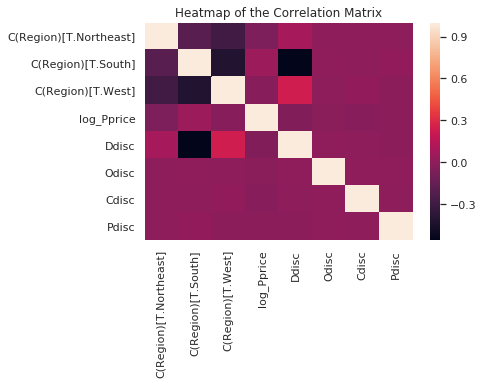

In [15]:
##
## Graph the correlation matrix
##
sns.heatmap( corr_matrix ).set_title( 'Heatmap of the Correlation Matrix' )

In [16]:
## 
## A fancy version of the heatmap
## Based on: https://stackoverflow.com/questions/39409866/correlation-heatmap
##
cmap = cmap = sns.diverging_palette( 5, 250, as_cmap = True )
##
corr_matrix.style.background_gradient( cmap, axis=1 ).set_precision( 1 )


,C(Region)[T.Northeast],C(Region)[T.South],C(Region)[T.West],log_Pprice,Ddisc,Odisc,Cdisc,Pdisc
C(Region)[T.Northeast],1,-0.2,-0.3,-0.06,0.09,-0.0004,0.0007,-0.002
C(Region)[T.South],-0.2,1,-0.4,0.05,-0.6,0.005,-0.002,0.009
C(Region)[T.West],-0.3,-0.4,1,-0.03,0.2,-0.002,0.01,-0.004
log_Pprice,-0.06,0.05,-0.03,1,-0.05,-0.02,-0.02,-0.01
Ddisc,0.09,-0.6,0.2,-0.05,1,0.004,-0.0003,-0.006
Odisc,-0.0004,0.005,-0.002,-0.02,0.004,1,0.004,0.004
Cdisc,0.0007,-0.002,0.01,-0.02,-0.0003,0.004,1,-0.0004
Pdisc,-0.002,0.009,-0.004,-0.01,-0.006,0.004,-0.0004,1


In [17]:
##
## Calculate VIFs
## The VIFs are the diagonal elements of the inverted correlation
## matrix of the independent variables.
##
## Subset the design matrix to eliminate the first column of 1s
## the iloc method says to find the location of columns based on their 
## integer locations (i.e., 0, 1, 2, etc.) the term in brackets says 
## to find all rows (the : ) and all columns from the first to the end (1: )
##
## create the correlation matrix
##
x = reg01.model.data.orig_exog.iloc[ :, 1: ]
corr_matrix = x.corr()
##corr_matrix
##
## invert the correlation matrix and extract the main diaginal
##
vif = np.diag( np.linalg.inv( corr_matrix ) ) 
##print( 'VIF: \n{}'.format( vif ) )
##
## zip the variable names and the VIFs
##
indepvars = [ i for i in x.columns ]
xzip = zip( indepvars, vif ) 
##
## Display the zip matrix
## First import a needed function:
##
from statsmodels.compat import lzip
lzip( xzip )

[(('C(Region)[T.Northeast]', 1.2725165717323543),),
 (('C(Region)[T.South]', 1.8699335998845652),),
 (('C(Region)[T.West]', 1.4674458719738115),),
 (('log_Pprice', 1.0083242238835004),),
 (('Ddisc', 1.4535047202292768),),
 (('Odisc', 1.0005481238934784),),
 (('Cdisc', 1.0006701768550137),),
 (('Pdisc', 1.0002001449342768),)]

The *VIF*s are all below 10 so there is no problem.

#### Model Portfolio

This is a nice way to summarize the models.

In [18]:
##
## Import some packags
##
from statsmodels.iolib.summary2 import summary_col
from statsmodels.stats.api import anova_lm
##
## Create a variable to hold the model names; this is a list.
## Note: the range() function specifies 1 - 2 but the "2" is
## not included.
##
model_names = [ 'Model ' + str( i ) for i in range( 1, 2 ) ]
##
## Create a variable to hold the statistics to print; this is a dictionary.
##
info_dict = { '\nn': lambda x: "{0:d}".format( int( x.nobs ) ),
              'R2 Adjusted': lambda x: "{:0.3f}".format( x.rsquared_adj ),
              'AIC': lambda x: "{:0.2f}".format( x.aic ),
              'F': lambda x: "{:0.2f}".format( x.fvalue ),
}
##
## Create the portfolio summary table.
##
summary_table = summary_col( [ reg01 ],
            float_format = '%0.2f',
            model_names = model_names,
            stars = True, 
            info_dict = info_dict 
)
summary_table.add_title( 'Summary Table for Living Room Blinds Sales' )
print( summary_table )


Summary Table for Living Room Blinds Sales
                       Model 1 
-------------------------------
Intercept              6.09*** 
                       (0.04)  
C(Region)[T.Northeast] 0.01    
                       (0.01)  
C(Region)[T.South]     -0.00   
                       (0.01)  
C(Region)[T.West]      -0.00   
                       (0.01)  
log_Pprice             -1.59***
                       (0.02)  
Ddisc                  1.84*** 
                       (0.06)  
Odisc                  1.91*** 
                       (0.15)  
Cdisc                  1.63*** 
                       (0.10)  
Pdisc                  1.65*** 
                       (0.18)  

n                     52690   
R2 Adjusted            0.199   
AIC                    72614.78
F                      1639.26 
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


#### <font color = black> Predicting with the Model </font>

Predict unit sales.  But recognize first that the sales for the model are in (natural) log terms.  You will convert back to unit sales in "normal" terms latter.

In [19]:
##
## Calculate predicted log of unit sales, the dependent variable
## Note: the inverse of the log is needed; use np.expm1( x )
## since log1p was used: np.expm1 = exp(x) - 1.
##
log_pred = reg01.predict( test )
y_pred = np.expm1( log_pred )
##
##
## Combine into one temporary DataFrame for convenience
##
tmp = pd.DataFrame( { 'y_test':y_test, 'y_logPred':log_pred, 'y_pred':y_pred } )
tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17568 entries, 47248 to 49985
Data columns (total 3 columns):
y_test       17568 non-null int64
y_logPred    17567 non-null float64
y_pred       17567 non-null float64
dtypes: float64(2), int64(1)
memory usage: 1.2 MB


Use the sklearn metric function r2_score to check the fit of actual vs. predicted values.  From the sklearn User Guide:

"*The r2_score function computes R², the coefficient of determination. It provides a measure of how well future samples are likely to be predicted by the model. Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.*"

In [20]:
##
## Import the r2_score function form the sklearn metric package
##
from sklearn.metrics import r2_score
##
## Display the r2 score.  But first drop any NaN data.
##
tmp.dropna( inplace = True )
print( round( r2_score( tmp.y_test, tmp.y_pred), 3 ) )

0.138


This is not very good.

You can also graph the actual vs predicted values.  Sometimes, however, the number of data points is too large to plot so a random sample may be needed.  This is our case.

[Text(0,0.5,'Predicted Sales'),
 Text(0.5,0,'Actual Sales'),
 Text(0.5,1,'Actual vs Predicted Units Sales\nRandom Sample of 500')]

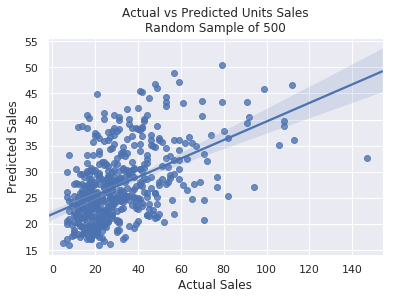

In [21]:
##
## Draw a random sample of 500 observations without replacement
## from the tmp DataFrame.
##
smpl = tmp.sample( n = 500, replace = False, random_state = 1 )
##
## Plot the data
##
ax = sns.regplot( x = 'y_test', y = 'y_pred', scatter = True, data = smpl )
ax.set( title = 'Actual vs Predicted Units Sales\nRandom Sample of 500', 
       ylabel = 'Predicted Sales', xlabel = 'Actual Sales' )

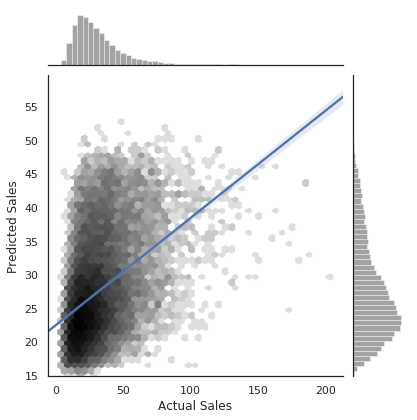

In [22]:
##
## Use the hex plot from above
##
with sns.axes_style("white"):
    g = sns.jointplot( x = 'y_test', y = 'y_pred', data = tmp, kind = 'hex',
                      color = 'k',
                  joint_kws={'gridsize':40, 'bins':'log'} )
    ax = sns.regplot( x = 'y_test', y = 'y_pred', data = tmp, ax = g.ax_joint,
                     scatter = False )
    ax.set( xlabel = 'Actual Sales', ylabel = 'Predicted Sales' )

Predict unit sales for different settings of the variables.  This is *scenario* or *what-if* analysis.

In [23]:
##
## Specify scenario values to use for prediction
##
## Create a dict
##
data = {
         'Pprice': [ 2.50 ],
         'Ddisc': [ 0.03 ],
         'Odisc': [ 0.05 ],
         'Cdisc': [ 0.03 ],
         'Pdisc': [ 0.03 ],
         'Region': [ 'West' ]
        }
##
## Create a DataFrame using the dict
##
scenario = pd.DataFrame.from_dict( data )
##
## Insert a log price column after the Pprice variable
##
scenario.insert( loc = 1, column = 'log_Pprice',
                value = np.log1p( scenario.Pprice ) )
##
## Display the settings and the predicted unit sales
##
print( 'Scenario settings:\n{}'.format( scenario ) )
##
## Create a pediction
##
log_pred = reg01.predict( scenario )
y_pred = np.expm1( log_pred )
print( '\nPredicted Unit Sales: \n{}'.format( round( y_pred, 0 ) ) )

Scenario settings:
   Pprice  log_Pprice  Ddisc  Odisc  Cdisc  Pdisc Region
0     2.5    1.252763   0.03   0.05   0.03   0.03   West

Predicted Unit Sales: 
0    76.0
dtype: float64


### <font color = blue> Exercises </font>

#### <font color = black> Exercise \#3.1 </font>

Test different scenarios for the above model and ask yourself: "*Are the results sensible?*"

#### <font color = black> Exercise \#3.2 </font>

Estimate a new *OLS* model by adding the buyer rating to the above model. Interpret your results. 

**Hint**: Buyer rating is categorical so you have to create dummies for the rating.

In [24]:
##
## Enter code here.  Insert cells below this if needed.
##


#### <font color = black> Case II: Logistic Regression </font>

#### <font color = black> Create your Data </font>

Customer satisfaction is part of the DataFrame.  Satisfaction is measured on a five-point scale: *1 = Not at All Satisfied*, *5 = Very Satisfied*.  

First, look at the frquency count of satisfaction.  But, there is a problem: you cannot use the same data as before since satisfaction is by customer and the data used so far is by transaction.  The satisfaction rating is in the customer DataFrame.  You need to first find the mean price and mean discounts by customer from the transactions DataFrame and then merge this new DataFrame with the customer DataFrame.  So, there are several steps:

1. Extract the pocket price and discounts -- include the *CID*
2. Group by the CID and calculate the means by *CID*
3. Merge with the customer DataFrame
4. Recode the scale values in the merged file so that 1 is the top-two values (called *top-two box* or *T2B*) and 0 is all other values.  The *T2B* is *Very Satisfied*.
5. Train a model with *T2B* satisfaction as a function of the pocket price, discounts, and Region.

In [25]:
## 
## ===> Step 1: Extract the pocket price and discounts -- include the CID
##
tmp = df[ [ 'CID', 'Pprice', 'Ddisc', 'Odisc', 'Cdisc', 'Pdisc' ] ]
tmp.set_index( 'CID', inplace = True )
tmp.shape

(70270, 5)

In [26]:
##
## ===> Step 2: Group by the CID and calculate the means by CID
##
x = tmp.groupby( 'CID' ).mean()
x.shape

(779, 5)

In [27]:
##
## ===> Step 3: Merge with the customer DataFrame
##
df_sat = x.merge( df_cust, left_index = True, right_index = True )
df_sat.head()
df_sat.shape

(306, 12)

In [28]:
##
## Do a quick check of the value distribution.
##
## Use the DataFrame's value_counts() method. Sort by the
## scale values 1 - 5.
##
df_sat.buyerSatisfaction.value_counts( sort = False )

1     16
2     30
3     47
4    179
5     34
Name: buyerSatisfaction, dtype: int64

In [29]:
##
## ===> Step 4: Recode the scale values so that 1 is the top-two values 
##(called *top-two box* or *T2B*) and 0 is all other values.  
## The *T2B* is *Very Satisfied*.
##
## Recode using Numpy's select function
##
## ===> Step 4.A: Define labels for the recoded values
##
lbl = [ 1, 0 ]
##
## ===> Step 4.B: Specify the conditions for the recoding
##
conditions = [
    ( df_sat.buyerSatisfaction >= 4 ),
    ( df_sat.buyerSatisfaction < 4 )
]
##
## ===> Step 4.C: Do the recoding 
##
df_sat[ 'sat_t2b' ] = np.select( conditions, lbl )
##
df_sat[ 'sat_t2b' ].value_counts( normalize = True )

1    0.696078
0    0.303922
Name: sat_t2b, dtype: float64

Model *T2B* satisfaction as a function of the pocket price and discounts.  First, create training and testing DataFrames as before but with *sat_t2b* as the *y* variable.

In [30]:
##
## ===> Step 5: Train a model.
##
## Create the X and y data for splitting
##
y = df_sat[ 'sat_t2b' ]
x = [ 'Pprice', 'Ddisc', 'Odisc', 'Cdisc', 'Pdisc', 'Region' ]
X = df_sat[ x ]
##
## Split the data.  The default is 3/4 train.
##
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, 
                                                    random_state = 42 )

In [31]:
##
## Display some data
##
print( 'Training Data: \n{}'.format( X_train.head() ) ) 
print( "\n" )
print( 'Testing Data: \n{}'.format( y_test.head() ) )

Training Data: 
        Pprice     Ddisc     Odisc     Cdisc     Pdisc     Region
166   5.883327  0.135245  0.048735  0.072857  0.039837      South
609   6.446667  0.142317  0.049556  0.072905  0.038556       West
663   7.289410  0.135538  0.052308  0.069333  0.043410    Midwest
1061  6.935050  0.137450  0.049125  0.067400  0.040975      South
372   7.294368  0.137748  0.048521  0.069607  0.039755  Northeast


Testing Data: 
741    0
667    0
578    1
815    0
345    1
Name: sat_t2b, dtype: int64


In [32]:
## 
## Merge the two training sets for convenience
##
yy = pd.DataFrame( { 'sat_t2b':y_train } )
train = yy.merge( X_train, left_index = True, right_index = True )
train.head()

,sat_t2b,Pprice,Ddisc,Odisc,Cdisc,Pdisc,Region
166,1,5.883327,0.135245,0.048735,0.072857,0.039837,South
609,1,6.446667,0.142317,0.049556,0.072905,0.038556,West
663,1,7.289410,0.135538,0.052308,0.069333,0.043410,Midwest
1061,1,6.935050,0.137450,0.049125,0.067400,0.040975,South
372,1,7.294368,0.137748,0.048521,0.069607,0.039755,Northeast


In [33]:
## 
## Merge the two testing sets for convenience
##
yy = pd.DataFrame( { 'sat_t2b':y_test } )
test = yy.merge( X_test, left_index = True, right_index = True )
test.head()

,sat_t2b,Pprice,Ddisc,Odisc,Cdisc,Pdisc,Region
741,0,7.893375,0.082292,0.050542,0.070208,0.043583,Midwest
667,0,7.303756,0.132511,0.053844,0.070067,0.039822,South
578,1,5.885723,0.133461,0.049092,0.069957,0.041766,South
815,0,8.368778,0.132511,0.052511,0.068000,0.038200,South
345,1,7.060585,0.128815,0.050748,0.069022,0.040830,Midwest


####  <font color = black> Train a Model </font>

In [34]:
##
## Train a logit model
##
## ===> Step 1: Define a formula
##
formula = 'sat_t2b ~ Pprice + Ddisc + Odisc + Cdisc + Pdisc + C( Region )'
##
## ===> Step 2: Instantiate the logit model
##
mod = smf.logit( formula, data = train )
##
## ===> Step 3: Fit the instantiated model
##
logit01 = mod.fit()
##
## ===> Step 4: Summarize the fitted model
##
print( logit01.summary() )

Optimization terminated successfully.
         Current function value: 0.599486
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                sat_t2b   No. Observations:                  205
Model:                          Logit   Df Residuals:                      196
Method:                           MLE   Df Model:                            8
Date:                Mon, 11 Feb 2019   Pseudo R-squ.:                 0.04591
Time:                        21:51:30   Log-Likelihood:                -122.89
converged:                       True   LL-Null:                       -128.81
                                        LLR p-value:                    0.1591
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -2.0429      8.029     -0.254      0.799     -17.780      

#### <font color = black> Analyze the Results </font>

In [35]:
##
## Import needed functions
##
from sklearn.metrics import confusion_matrix, classification_report
##
## Make predictions
##
predictions = logit01.predict( test )
predictions_nominal = [ 0 if x < 0.5 else 1 for x in predictions]
print( classification_report( y_test, predictions_nominal, digits = 3 ) )

              precision    recall  f1-score   support

           0      0.667     0.148     0.242        27
           1      0.758     0.973     0.852        74

   micro avg      0.752     0.752     0.752       101
   macro avg      0.712     0.561     0.547       101
weighted avg      0.734     0.752     0.689       101



For binary classification, the count of **true negatives** ($tn$), **false negatives** ($fn$), **true positives** ($tp$), and **false positives** ($fp$) can be found from a *confusion matrix*.

In [36]:
##
## Create a confusion matrix
##
x = confusion_matrix(y_test, predictions_nominal).ravel()
##
## zip the variable names and the confusion
##
lbl = [ 'tn', 'fp', 'fn', 'tp' ]
##
## display the zip matrix
##
from statsmodels.compat import lzip
lzip( zip( lbl, x ) )


[(('tn', 4),), (('fp', 23),), (('fn', 2),), (('tp', 72),)]

Plot the confusion matrix

Confusion Matrix: 
               Not Satisfied  Satisfied
Not Satisfied              4         23
Satisfied                  2         72


[Text(0,0.5,''), Text(0,1.5,'Not Satisfied')]

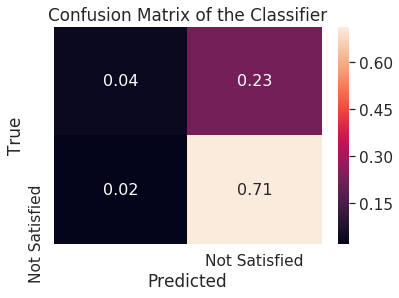

In [37]:
##
## Create labels
##
lbl = ['Not Satisfied', 'Satisfied']
##
## Create the confusion matrix
##
cm = confusion_matrix( y_test, predictions_nominal )
tmp = pd.DataFrame(data=cm, index = lbl, columns = lbl )
print( 'Confusion Matrix: \n{}'.format( tmp ) )
##
## Plot the confusion matrix
##
##ax = sns.heatmap( cm )
sns.set( font_scale = 1.4 )   #for label size
ax = sns.heatmap( cm/cm.sum(), annot = True, annot_kws = { "size": 16 } )  # font size
ax.set( title = 'Confusion Matrix of the Classifier', xlabel = 'Predicted',
       ylabel = 'True' )
ax.set_xticklabels([''] + lbl)
ax.set_yticklabels([''] + lbl)

#### Model Portfolio

In [38]:
model_names = [ 'Model ' + str( i ) for i in range( 1, 2 ) ]
##
## Create a variable to hold the statistics to print; this is a dictionary.
##
info_dict = { '\nn': lambda x: "{0:d}".format( int( x.nobs ) ),
}
##
## Create the portfolio summary table.
##
summary_table = summary_col( [ logit01 ],
            float_format = '%0.2f',
            model_names = model_names,
            stars = True, 
            info_dict = info_dict 
)
summary_table.add_title( 'Summary Table for Living Room Blinds Sales' )
print( summary_table )

Summary Table for Living Room Blinds Sales
                       Model 1
------------------------------
Intercept              -2.04  
                       (8.03) 
C(Region)[T.Northeast] 1.35*  
                       (0.70) 
C(Region)[T.South]     0.62   
                       (0.39) 
C(Region)[T.West]      0.43   
                       (0.38) 
Pprice                 -0.31* 
                       (0.17) 
Ddisc                  6.65   
                       (7.23) 
Odisc                  48.05  
                       (78.59)
Cdisc                  68.83  
                       (63.93)
Pdisc                  -87.74 
                       (97.24)

n                     205    
Standard errors in
parentheses.
* p<.1, ** p<.05, ***p<.01


#### <font color = black> Predicting with the Model </font>

The prediction process is the same as discussed for Case I above.

### <font color = blue> Exercises </font>

#### <font color = black> Exercise \#3.3 </font>

Use the testing data to test the model fit.

In [39]:
##
## Enter code here.  Insert cells below this if needed.
##

## <font color = black> Growing Decision Trees </font>

Decision Trees can handle continuous or discrete dependent variables.  They are an alternative to *OLS* and logistic regression: you don't have to specify a "model" *per se*.  They also have the advantage that a visual display, a *tree*, is produced which is easier for managment and clients to understand than complex regression output and statistics.  You will only look at a discrete case; a continuous case is the same.

In [40]:
##
## Import decision tree classifier
##
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn import preprocessing
from sklearn.tree import export_graphviz
##
## Convert "Region" to integers: the decision tree must have all numerics
## Note: use the LabelEncoder function for this
##
le = preprocessing.LabelEncoder()
X_train = X_train.apply( le.fit_transform )
print( 'Training Data: \n{}\n'.format( X_train.head() ) )
##
X_test = X_test.apply( le.fit_transform )
print( 'Testing Data: \n{}'.format( X_test.head() ) )
##
## Instantiate the tree
##
dtree = tree.DecisionTreeClassifier( random_state = 0, max_depth = 3, 
                                    min_samples_leaf = 5 )
##
## Fit the tree
##
dtree.fit( X_train, y_train )

Training Data: 
      Pprice  Ddisc  Odisc  Cdisc  Pdisc  Region
166       28    127     50    181     92       2
609       55    195     75    183     33       3
663      118    137    184     69    199       0
1061      85    161     67     25    158       2
372      124    165     46     82     85       1

Testing Data: 
     Pprice  Ddisc  Odisc  Cdisc  Pdisc  Region
741      81     15     53     59     98       0
667      64     38     99     57     42       2
578      18     47     17     54     90       2
815      93     38     92     18      5       2
345      56     21     59     34     74       0


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

Some additional packages are needed to plot a decision tree:

- graphviz
- pydotplus


In [41]:
##
## Both packages may have to be installed before they can be used.  
## Use the operating system to do this.
##
import os
!{sys.executable} -m pip install graphviz
!{sys.executable} -m pip install pydotplus
##
## Tell Python where the graphviz package is load; then load it.
##
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
##
## Load the following packages
##
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import graphviz
import pydotplus

/bin/sh: 1: {sys.executable}: not found
/bin/sh: 1: {sys.executable}: not found


#### <font color = black> Check model accuracy </font>

In [41]:
##
## The score attribute
##
print( "Accuracy on training data: {:.3f}".format( dtree.score( X_train, y_train )))
print( "Accuracy on testing data: {:.3f}".format( dtree.score( X_test, y_test )))

Accuracy on training data: 0.766
Accuracy on testing data: 0.604


These are good scores.

#### <font color = black> Display the decision tree </font>

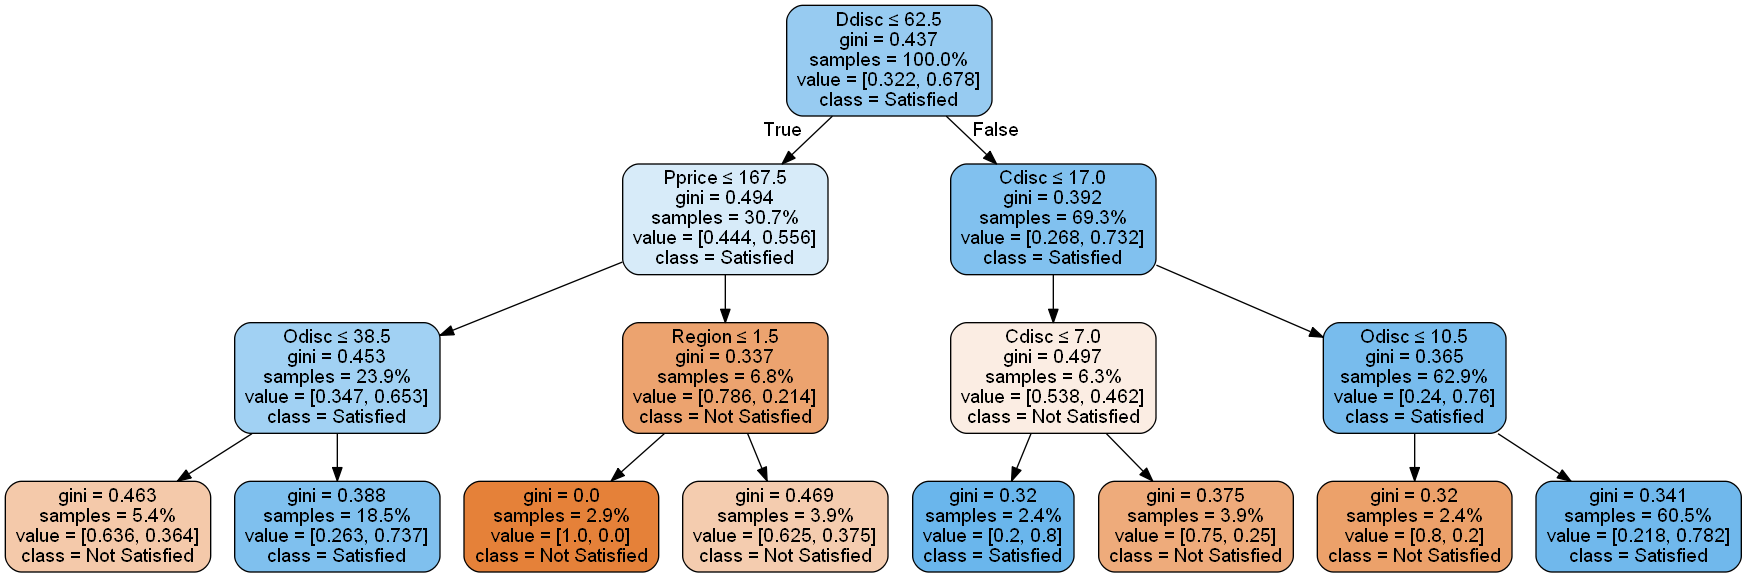

In [42]:
##
## Displaying a tree is a slight challenge!
## There are four steps:
##
## ===> Step 1: Create a placeholder for all the plotting points.
##
dot_data = StringIO()
##
## ===> Step 2: Extract the feature names for labels models
##
feature_names = [ i for i in X_train.columns ]
##
## ===> Step 3: Export the plotting data to the placeholder
##
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                class_names = [ 'Not Satisfied', 'Satisfied' ],
                feature_names = feature_names ,
                proportion  = True
               )
##
## ===> Step 4: Create the display
##
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### <font color = blue> Exercises </font>

#### <font color = black> Exercise \#3.4 </font>

Interpret the decision tree.

## <font color = black> What's Next? </font>

In Lesson 4, I will briefly discuss how to share your notebooks.  Recall that there are three reasons for using Jupyter notebooks in your analysis work:

1. managing workflows;
2. documenting analyses for reproducibility; and
3. sharing results with colleagues.

I'll discuss these in the next lesson.
<br><br><br>
<font color = red, size = "+3"><b> Five Minute Break </font>